In [1]:
import sys
sys.path.append('..')
import edlib
import numpy as np
from collections import Counter, defaultdict
import operator
from string import ascii_uppercase


from lrd_parser import LRD_Report
from utils.bio import hamming_distance, identity_shift, OverlapAlignment, compress_homopolymer
import networkx as nx

import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from ndex2.nice_cx_network import NiceCXNetwork
import ndex2.client as nc
import ndex2

%load_ext autoreload
%autoreload 2

In [2]:
lrd_report_fn = '/Poppy/abzikadze/centroFlye/centroFlye_repo/experiments/20191023/lrd_d6z1_rel3_Karen/decomposition.tsv'
monomers_fn = "/Poppy/abzikadze/tandem_flye/data/human/isolated_centromeres/extracted_HORs/CEN6/monomers/inferred_monomers_single.fa"

lrd_report = LRD_Report(lrd_report_fn=lrd_report_fn, monomers_fn=monomers_fn)

In [141]:
def get_frequent_kmers(lrd_report, k, min_mult=15):
    all_kmers = Counter()
    read_kmer_locations = defaultdict(list)
    for r_id, record in lrd_report.records.items():
        string = record.string
        for i in range(len(string)-k+1):
            kmer = string[i:i+k]
            if '=' not in kmer:
                all_kmers[kmer] += 1
                read_kmer_locations[kmer].append((r_id, i))
                
    frequent_kmers = {kmer: cnt for kmer, cnt in all_kmers.items()
                      if cnt >= min_mult}
    frequent_kmers_read_pos = {kmer: read_kmer_locations[kmer] for kmer in frequent_kmers}
    return frequent_kmers, frequent_kmers_read_pos


In [168]:
k=150
frequent_kmers, frequent_kmers_read_pos = get_frequent_kmers(lrd_report, k=k)

In [169]:
class DeBruijnGraph:
    def __init__(self, k):
        self.graph = nx.DiGraph()
        self.k = k

    def add_kmer(self, kmer, coverage=1):
        self.graph.add_edge(kmer[:-1], kmer[1:],
                            edge_kmer=kmer,
                            coverages=[coverage])

    def add_kmers(self, kmers, coverage=None):
        for kmer in kmers:
            if coverage is None:
                self.add_kmer(kmer)
            else:
                self.add_kmer(kmer, coverage=coverage[kmer])


In [170]:
db = DeBruijnGraph(k=k)
db.add_kmers(frequent_kmers, coverage=frequent_kmers)

In [171]:
nx.is_directed_acyclic_graph(db.graph)

False

In [172]:
def get_read_coverage(frequent_kmers_read_pos, lrd_report, k):
    coverage = {}
    for r_id in lrd_report.records:
        coverage[r_id] = [0] * (len(lrd_report.records[r_id].string) + 1)
    for pairs in frequent_kmers_read_pos.values():
        for r_id, pos in pairs:
            coverage[r_id][pos] += 1
            coverage[r_id][pos+k] -= 1
    for r_id in coverage:
        coverage[r_id] = np.cumsum(coverage[r_id])
        coverage[r_id] = coverage[r_id][:-1]
    return coverage

In [173]:
coverage = get_read_coverage(frequent_kmers_read_pos=frequent_kmers_read_pos,
                             lrd_report=lrd_report,
                             k=k)

In [174]:
coverage.keys()

dict_keys(['00739941-c14c-40bd-9fad-fabff753795b', '01f80610-395e-4ef8-93d0-526989b8cb53', '0352811e-b17c-4fc1-a73f-99757d30745c', '03e1fc3d-8e77-4170-94e1-3711db044f8b', '04203cad-4a32-4b9c-b7dd-c8603e54b46b', '04b2f961-f6b4-438d-9a64-83dbd6049ffc', '050b88c4-e343-431d-99dc-4b8151b4adef', '0540aa3e-f34b-4e74-a5e5-884b69594a0d', '054f1983-9204-4889-936a-64ab45e7810c', '0550a437-3d6c-47d9-8a69-c6793852bd89', '057047e6-eb15-4d39-b4f6-473ecba0558a', '05a4fa6a-38b1-40d6-916e-886ad1fb050b', '05c5a912-42ad-4a57-ae81-0a318dc8c6b7', '063b3d2c-c9b3-4292-861f-2839fc294b2b', '079aa8c8-90a4-4fe8-af37-d9170f7d82b7', '0866791e-4ea1-4b1e-aa7a-2f437a87e866', '08a68948-5d96-4ed2-9632-c86d0200d914', '0aca72fc-0a1e-416a-beb5-6b4bde55eb81', '0b1f944b-90f7-4e17-a1cd-f02d38d0f84c', '0b6b3bce-3f57-4c84-b5a5-ceca6311adaa', '0b928976-0529-4907-b3a4-d15847c31fb5', '0c0dd3f7-6828-447b-ac53-1d118b0270a0', '0c20902b-e7d8-44ea-9edf-179fc2b83208', '0c50866b-f780-4551-a4bb-aa35a72f3f4d', '0c849de1-fbde-4ff4-bf9e-a767

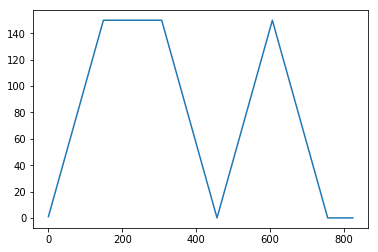

In [201]:
r_id = '0c0dd3f7-6828-447b-ac53-1d118b0270a0'
plt.plot(coverage[r_id])

In [202]:
lrd_report.records[r_id].string

'FGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHI=KLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHI===MNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKL'

In [203]:
def find_zero_cov(coverage, lrd_report):
    all_zero_cov = {}
    for r_id in coverage:
        zero_cov_flatten = np.where(coverage[r_id] == 0)[0]
        if len(zero_cov_flatten) == 0:
            all_zero_cov[r_id] = []
            continue
        zero_cov = []
        zero_cov.append([zero_cov_flatten[0]])
        for pos in zero_cov_flatten[1:]:
            if pos == zero_cov[-1][-1] + 1:
                zero_cov[-1].append(pos)
            else:
                zero_cov.append([pos])
        
        all_zero_cov[r_id] = [(x[0], x[-1]) for x in zero_cov]
        
    return all_zero_cov

In [204]:
zero_cov = find_zero_cov(coverage=coverage,
                         lrd_report=lrd_report)

In [220]:
def find_path_debr(zero_cov, read_seq, k, db):
    k -= 1
    for st, en in zero_cov:
        print(st, en)
        if st < k or en > len(read_seq) - 1 - k:
            continue
        st_kmer, en_kmer = read_seq[st-k:st], read_seq[en+1:en+1+k]
        # assert st_kmer in frequent_kmers
        # assert en_kmer in frequent_kmers
        assert read_seq[st-k+1:st+1] not in frequent_kmers
        assert read_seq[en:en+k] not in frequent_kmers
        assert st_kmer in db.graph.nodes
        # print(st_kmer, en_kmer)
        
        u = st_kmer
        kmers = [u]
        failure = False
        while u != en_kmer and not failure:
            out_edges = list(db.graph.out_edges(u))
            # print(len(kmers))
            # print(out_edges)
            if len(out_edges) == 1:
                edge = out_edges[0]
                assert edge[0] == u
                u = edge[1]
                kmers.append(u)
            else:
                failure = True
                break
        if not failure:
            assert u == en_kmer
            path = [kmers[0]]
            for kmer in kmers[1:]:
                path.append(kmer[-1])
            path = ''.join(path)
            print(kmers)
            print(path)
            print(read_seq[st-k:en+1+k])
            assert path[:k] == st_kmer
            assert path[-k:] == en_kmer
            print(k, len(path), st, en)

In [221]:
#for r_id in zero_cov:
print(r_id)
find_path_debr(zero_cov[r_id], lrd_report.records[r_id].string, k=k, db=db)

0c0dd3f7-6828-447b-ac53-1d118b0270a0
457 457
['EFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHI', 'FGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJ', 'GHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJK', 'HIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKL', 'IJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLM', 'JKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMN', 'KLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHI

In [222]:
"EFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNO"



'EFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNO'